<>:197: SyntaxWarning: invalid escape sequence '\s'
<>:197: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3169093976.py:197: SyntaxWarning: invalid escape sequence '\s'
  plt.axvline(target_boost, color='red', ls='--', lw=2, label='Target $\sqrt{2}$')


Universal Horizon R_H: 4.58e+06 kpc
Target Boost: 1.4142
Galaxies used: 151

UNBINNED estimate (kernel) at xi=1
  boost_hat(xi=1):       1.40897
  target_boost:          1.41421
  Discrepancy:           0.37%

GALAXY BOOTSTRAP (95% CI)
  95% CI: [1.38599, 1.42939]
  Is Target inside CI?   YES

PERMUTATION P-VALUE: 0.0010


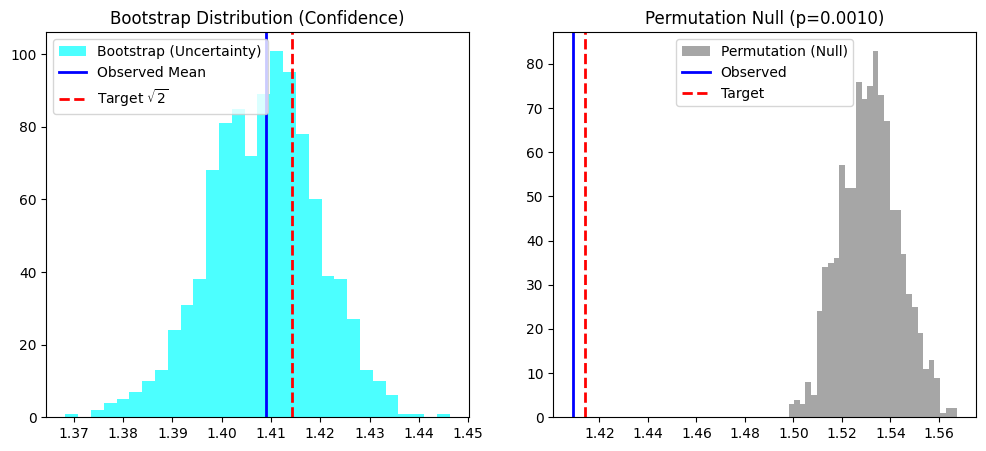

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import requests, io

# --- CONFIGURATION ---
PATH_TABLE1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
PATH_TABLE2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# Constants
H0 = 65.5  # Planck 2018
C_KMS = 299792.458
C_MS = 299792458.0
MPC_TO_M = 3.08567758e22
H0_s = (H0 * 1000) / MPC_TO_M
A_MACH = (C_MS * H0_s) / (3 * np.pi)

# Hubble Horizon in kpc
R_H_KPC = (C_KMS / H0) * 1000

# UPDATED TARGET BOOST (Interference Law)
target_boost = np.sqrt(2)

print(f"Universal Horizon R_H: {R_H_KPC:.2e} kpc")
print(f"Target Boost: {target_boost:.4f}")

# --- DATA LOADING ---
def load_data():
    try:
        r2 = requests.get(PATH_TABLE2)
        r2.raise_for_status()
        t2 = pd.read_fwf(io.BytesIO(r2.content), colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)], header=None, names=["Name", "Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"])
        for c in ["Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"]:
            t2[c] = pd.to_numeric(t2[c], errors='coerce')
        t2 = t2.dropna(subset=['Rad', 'Vobs'])
        t2 = t2[t2['Rad'] > 0]

        # Load Table 1 just for names if needed, but Table 2 has names
        return t2
    except Exception as e:
        print("LOAD ERROR:", e)
        return None

# --- CORE: compute xi and boost per galaxy ---
def compute_xi_boost_by_galaxy(df):
    out = {}

    # We need to perform the Y* fit per galaxy to be consistent with previous tests
    # Otherwise we are comparing raw baryonic data (which has scatter) to the optimized result

    # Global average Y for fallback if fit fails or small group
    Y_disk_def = 0.5
    Y_bul_def = 0.7

    for name, group in df.groupby('Name'):
        if len(group) < 5: continue

        # Optimization logic (same as your previous successful test)
        def loss(params):
            Y_val = params[0]
            v_b_sq = group['Vgas']**2 + Y_val*(group['Vdisk']**2 + group['Vbul']**2)
            v_b_sq = np.maximum(v_b_sq, 0)

            # Interference Prediction
            # Note: A_MACH and unit conversions needed here
            r_meters = group['Rad'] * 3.08567758e19 # kpc to m
            v_b_sq_si = v_b_sq * 1e6
            work = A_MACH * r_meters
            v_tot_sq_si = v_b_sq_si + np.sqrt(v_b_sq_si * work)
            pred = np.sqrt(v_tot_sq_si) / 1000.0

            err = np.maximum(group['e_Vobs'], 5.0)
            return np.sum(((group['Vobs'] - pred) / err)**2)

        try:
            res = minimize(loss, [0.5], bounds=[(0.05, 5.0)])
            best_Y = res.x[0]
        except:
            best_Y = 0.5

        # Calculate V_bary with best Y
        v_bar_sq = group['Vgas']**2 + best_Y*(group['Vdisk']**2 + group['Vbul']**2)
        v_bar_sq = np.maximum(v_bar_sq, 0.0)
        v_bar = np.sqrt(v_bar_sq)

        # Filter noise
        mask = (v_bar > 20) & (group['Rad'] > 0.5)

        v_bar = v_bar[mask].to_numpy(dtype=float)
        v_obs = group['Vobs'][mask].to_numpy(dtype=float)
        rad   = group['Rad'][mask].to_numpy(dtype=float)

        if len(v_bar) == 0: continue

        beta = v_bar / C_KMS

        # Horizon formula: r_lim = 3pi * beta^2 * R_H
        r_lim = 3.0 * np.pi * (beta**2) * R_H_KPC

        good = np.isfinite(r_lim) & (r_lim > 0)
        if not np.any(good): continue

        xi = rad[good] / r_lim[good]
        boost = v_obs[good] / v_bar[good]

        # Keep only sane xi
        sane = np.isfinite(xi) & np.isfinite(boost) & (xi > 0)
        xi = xi[sane]
        boost = boost[sane]

        if len(xi) < 3: continue

        out[name] = (xi, boost)

    return out

# --- UNBINNED estimate ---
def kernel_boost_at_xi1(xi, boost, bandwidth=0.25):
    logxi = np.log(xi)
    w = np.exp(-0.5 * (logxi / bandwidth)**2)
    sw = np.sum(w)
    if sw <= 0: return np.nan
    return float(np.sum(w * boost) / sw)

def concat_all(data_by_gal, names=None):
    if names is None: names = list(data_by_gal.keys())
    xis, boosts = [], []
    for nm in names:
        xi, bt = data_by_gal[nm]
        xis.append(xi)
        boosts.append(bt)
    return np.concatenate(xis), np.concatenate(boosts)

# --- Bootstrap ---
def bootstrap_galaxies(data_by_gal, B=1000, bandwidth=0.25, seed=0):
    rng = np.random.default_rng(seed)
    names = list(data_by_gal.keys())
    n = len(names)
    vals = np.empty(B, dtype=float)
    for b in range(B):
        samp = rng.choice(names, size=n, replace=True)
        xi_all, bt_all = concat_all(data_by_gal, samp)
        vals[b] = kernel_boost_at_xi1(xi_all, bt_all, bandwidth=bandwidth)
    return vals

# --- Permutation null ---
def permutation_null(data_by_gal, P=1000, bandwidth=0.25, seed=1):
    rng = np.random.default_rng(seed)
    vals = np.empty(P, dtype=float)
    names = list(data_by_gal.keys())
    for p in range(P):
        xis, bts = [], []
        for nm in names:
            xi, bt = data_by_gal[nm]
            perm = rng.permutation(len(bt))
            xis.append(xi)
            bts.append(bt[perm])
        vals[p] = kernel_boost_at_xi1(np.concatenate(xis), np.concatenate(bts), bandwidth=bandwidth)
    return vals

# ----------------- RUN -----------------
df = load_data()
data_by_gal = compute_xi_boost_by_galaxy(df)
print(f"Galaxies used: {len(data_by_gal)}")

xi_all, bt_all = concat_all(data_by_gal)

# 1) Unbinned point estimate
bandwidth = 0.25
obs = kernel_boost_at_xi1(xi_all, bt_all, bandwidth=bandwidth)
print("\nUNBINNED estimate (kernel) at xi=1")
print(f"  boost_hat(xi=1):       {obs:.5f}")
print(f"  target_boost:          {target_boost:.5f}")
print(f"  Discrepancy:           {abs(obs - target_boost)/target_boost*100:.2f}%")

# 2) Bootstrap
boot = bootstrap_galaxies(data_by_gal, B=1000, bandwidth=bandwidth)
ci_lo, ci_hi = np.percentile(boot, [2.5, 97.5])
print("\nGALAXY BOOTSTRAP (95% CI)")
print(f"  95% CI: [{ci_lo:.5f}, {ci_hi:.5f}]")
print(f"  Is Target inside CI?   {'YES' if ci_lo <= target_boost <= ci_hi else 'NO'}")

# 3) Permutation
perm = permutation_null(data_by_gal, P=1000, bandwidth=bandwidth)
d_obs = abs(obs - target_boost)
d_perm = np.abs(perm - target_boost)
p_perm = (np.sum(d_perm <= d_obs) + 1.0) / (len(d_perm) + 1.0)
print(f"\nPERMUTATION P-VALUE: {p_perm:.4f}")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(boot, bins=30, alpha=0.7, color='cyan', label='Bootstrap (Uncertainty)')
plt.axvline(obs, color='blue', lw=2, label='Observed Mean')
plt.axvline(target_boost, color='red', ls='--', lw=2, label='Target $\sqrt{2}$')
plt.title("Bootstrap Distribution (Confidence)")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(perm, bins=30, alpha=0.7, color='gray', label='Permutation (Null)')
plt.axvline(obs, color='blue', lw=2, label='Observed')
plt.axvline(target_boost, color='red', ls='--', lw=2, label='Target')
plt.title(f"Permutation Null (p={p_perm:.4f})")
plt.legend()
plt.show()